# Remapping with `cdo` for latitude binning

Averaging over a latitude span resulted to be challenging for data on the native grid. Therefore I turned to `cdo` to remap my data. Integrating over the latitude dimension is then straight forward.

Any code that generates warnings will no longer print them to the console.


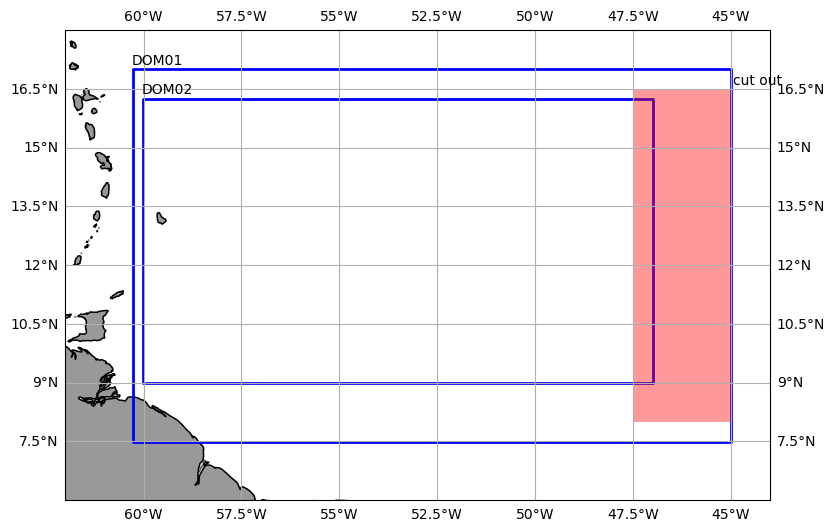

In [59]:
import sys
import os
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path:
    sys.path.append(module_path)
import file_handling as fh
fh.disable_warnings()

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from matplotlib.patches import Rectangle, Circle
from matplotlib.collections import PatchCollection
import cartopy.feature as cfeature
import numpy as np
import postprocessing as pp

def add_map_view(ax, map_projection, latlon_limits, colored_map=False, gridlines=True):
    # decorations
    ax.coastlines()
    if colored_map:
        # (https://techoverflow.net/2021/04/25/how-to-add-colored-background-to-cartopy-map/)
        ax.stock_img()
    else:
        # or just color the land:
        ax.add_feature(cfeature.LAND, facecolor='black', alpha=0.4)
    ax.set_extent(latlon_limits, ccrs.PlateCarree())
    if gridlines:
        ax.gridlines(draw_labels=True, crs=map_projection)

def add_rectangles(ax, rectangles):
    # Create patch collection with specified colour/alpha, inside the loop, because it can not be reused
    pc = PatchCollection(rectangles, facecolor='none', alpha=1, edgecolor='blue', linewidth=2, zorder=2)    
    ax.add_collection(pc)
    return ax
    
def eureca_domain_rectangles(domains=['DOM01','DOM02'],):
    # get extents of grids as rectangles
    rectangles = list()
    for dom in ['DOM01','DOM02']:
        grid = xr.open_zarr(f"https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/grids/EUREC4A_PR1250m_{dom}.zarr")
        # anker, extent = rectangle_anker(grid)
        # rectangles.append(Rectangle(anker, *extent))
        rectangles.append(pp.rectangle(grid))
    return rectangles

def rectangle_anker(grid):
    lonlim = [np.rad2deg(l) for l in (np.min(grid.clon.values), np.max(grid.clon.values))]
    latlim = [np.rad2deg(l) for l in (np.min(grid.clat.values), np.max(grid.clat.values))]
    anker  = (lonlim[0], latlim[0]) # Rectangle demands coordinates for lower left corner + height and width
    extent = (lonlim[1] - lonlim[0], latlim[1] - latlim[0])
    return anker, extent

def fig_grid_rectangles(latlon_limit_list):
    projection = ccrs.PlateCarree(central_longitude=0)
    fig = plt.figure(figsize=[20, 10])
    axs = list()

    for i, latlon_limit in enumerate(latlon_limit_list): 
        ax = fig.add_subplot(1, len(latlon_limit_list)+1, i+1, projection=projection)
        add_map_view(ax, projection, latlon_limit)
        # add_rectangles(ax, eureca_domain_rectangles())
        axs.append(ax)
        
    for dom in ['DOM01','DOM02']:
        grid = xr.open_zarr(f"https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/grids/EUREC4A_PR1250m_{dom}.zarr")
        rectangle = pp.rectangle(grid)
        pc = PatchCollection([rectangle], facecolor='none', alpha=1, edgecolor='blue', linewidth=2, zorder=2)    
        ax.add_collection(pc)
        anker, extent = rectangle_anker(grid)
        ax.annotate(dom, (anker[0], anker[1]+extent[1]), xytext=(-2,5), textcoords='offset pixels')
    return fig, axs

def fig_rectangle_on_domains(rectangle):
    fig, axs = fig_grid_rectangles([(-62,-44,+6,+18)])
    ax = axs[0]
    pc = PatchCollection([rectangle], facecolor='red', alpha=0.4, edgecolor='none', linewidth=2, zorder=2)   
    # anker, extent = rectangle_anker(grid)
    anker = rectangle.get_xy()
    extent = rectangle.get_width(), rectangle.get_height()
    ax.annotate('cut out', (anker[0]+extent[0], anker[1]+extent[1]), xytext=(2, 5), textcoords='offset pixels')
    ax.add_collection(pc)
    return fig, ax


lat_lon_iterable = ((13.0, 16.0), (-45.0, -47.5)) # small patch
lat_lon_iterable = (( 8.0, 16.5), (-45.0, -47.5)) # longer lat extent
rectangle = pp.rectangle(lat_lon_iterable)

fig, ax = fig_rectangle_on_domains(rectangle)
fig.show()

In [60]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import os
import postprocessing as pp
import file_handling as fh
import subprocess

def grid_description(rectangle, shape):
    """
    Create a description for a regular global grid with the specified shape.

    This function generates a description for a regular global grid based on the provided Rectangle object and shape.
    The shape parameter should be a tuple of two integers representing the number of grid cells along the y and x axes, respectively.

    Parameters:
    - rectangle (matplotlib.patches.Rectangle): The Rectangle object defining the spatial extent of the grid.
    - shape (tuple): A tuple of two integers representing the shape of the grid in terms of the number of grid cells
      along the y and x axes, respectively.

    Returns:
    - str: A string containing a description of the grid in a format suitable for configuration files or documentation.

    Raises:
    - ValueError: If the shape parameter is not a tuple of two integers.

    Example:
    min_lat, max_lat, min_lon, max_lon = 13.0, 16.0, -47.5, -50.0
    anker = (min_lon, min_lat)
    extent = (max_lon - min_lon, max_lat - min_lat)
    rect = matplotlib.patches.Rectangle(anker, *extent)
    description  = grid_description(rect, (1,100))
    griddes_file = save_griddescription(description, tempdir)
    """
    if isinstance(shape, tuple) and len(shape) == 2 and all(isinstance(val, int) for val in shape):
        ysize, xsize = shape
    else: raise ValueError("shape must be a pair of integers.")

    lat_ext, lon_ext = pp.rectangle_latlon_extent(rectangle)
    yfirst = lat_ext[0]
    xfirst = lon_ext[0]
    xinc = (lon_ext[1] - lon_ext[0]) / xsize
    yinc = (lat_ext[1] - lat_ext[0]) / ysize
 
    lines = [
        f'gridtype  = lonlat',
        f'gridsize  = {int(xsize * ysize)}',
        f'xsize     = {int(xsize)}',
        f'ysize     = {int(ysize)}',
        f'xfirst    = {xfirst}',
        f'xinc      = {xinc}',
        f'yfirst    = {yfirst}',
        f'yinc      = {yinc}',
        'xname     = lon',
        'xlongname = "longitude"',
        'xunits    = "degrees_east"',
        'yname     = lat',
        'ylongname = "latitude"',
        'yunits    = "degrees_north"',
        '']
    return "\n".join(lines)

def griddescription2dict(description):
    """
    Convert a grid description string into a dictionary.

    This function parses a grid description string and converts it into a dictionary format, 
    where each line of the description represents a key-value pair in the dictionary.

    Parameters:
    - description (str): A string containing the grid description.

    Returns:
    - dict: A dictionary containing the parsed key-value pairs from the grid description string.
    """
    description = description.split('\n')
    dictionary = dict()
    for line in description:
        try:
            key, value = line.split('=')
            dictionary[key.strip()] = value.strip()
        except: pass
    return dictionary

def griddescription2name(description):
    """
    Generate a name for the grid based on its description.

    This function generates a name for the grid based on the provided grid description.
    The generated name includes information about the grid type, size, latitude span, and longitude span.

    Parameters:
    - description (str): A string containing the grid description.

    Returns:
    - str: A formatted name for the grid based on its description.
    """
    des = griddescription2dict(description)
    size    = f"{int(des['xsize'])}x{int(des['ysize'])}"
    latspan = f"{float(des['yfirst']):.1f}to{float(des['yfirst']) + float(des['ysize']) * float(des['yinc']):.1f}N"
    lonspan = f"{float(des['xfirst']):.1f}to{float(des['xfirst']) + float(des['xsize']) * float(des['xinc']):.1f}E"
    return f"grid_{des['gridtype']}_{size}_{latspan}_{lonspan}.txt"

def save_griddescription(description, directory='/scratch/m/m300872/temp/'):
    """
    Save the grid description to a file.

    This function saves the provided grid description to a file with a name generated based on the description.
    The file is saved in the specified directory or the default directory if not provided.

    Parameters:
    - description (str): A string containing the grid description.
    - directory (str, optional): The directory where the file will be saved. Defaults to '/scratch/m/m300872/temp/'.

    Returns:
    - str: The file path of the saved grid description.
    """
    file_name = directory + griddescription2name(description)
    with open(file_name, 'w') as f:
        f.write(description)
    return file_name


In [62]:
tempdir = '/scratch/m/m300872/temp_20230220/'
os.makedirs(tempdir, exist_ok=True)
source_grid = '/work/mh1126/m300872/unchanged/grids/EUREC4A_PR1250m_DOM01.nc'

rect = pp.rectangle(lat_lon_iterable)
griddes  = grid_description(rect, (1,100))
griddes_file = save_griddescription(griddes, tempdir)

weight_file = f'{tempdir}weights.nc'
weight_file = os.path.join(tempdir, f'{fh.basename(griddescription2name(griddes))}_weights.nc')

path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_06_pfix'
infiles = fh.list_files(path, ['DOM01_3D'], full_path=True)
dummy_infile = infiles[0]

command = ['cdo', '-O', f'-gendis,{griddes_file}', f'-setgrid,{source_grid}:2', dummy_infile, weight_file] # -O : overwrite
print(' '.join(command), '\n')
subprocess.run(command, stdout=open(os.devnull, 'wb'))

outfiles = list()
print(f'processing {len(infiles)} files')
i = 0
for infile in infiles:
    outfile = os.path.join(tempdir, f'{fh.basename(infile)}_regridded.nc')
    print(str(i).rjust(2), outfile); i += 1
    command = ['cdo', '-O', f'remap,{griddes_file},{weight_file}', f'-setgrid,{source_grid}:2', infile, outfile]
    script = fh.slurm_header(binary_path='/bin/bash')
    script += ' '.join(command)
    script += '\n'
    script_path = f'{tempdir}/cdo_regrid_{str(i).rjust(2,"0")}.sh'
    script_path = f'{tempdir}/cdo_regrid.sh'
    with open(script_path, 'w') as f: f.write(script)
    subprocess.run(['sbatch', script_path], stdout=open(os.devnull, 'wb'))
    outfiles.append(outfile)

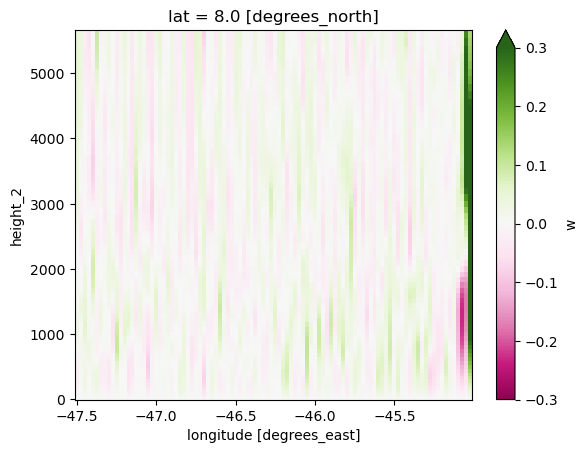

In [63]:
import calculations as cc
import numpy as np
import xarray as xr

def replace_height_indices_with_values(data, height_names=['height', 'height_2']):
    """
    Replace height indices with corresponding values in the dataset.

    This function replaces the height indices in the dataset with the corresponding height values.
    It iterates over the specified height names and replaces their indices with the corresponding values.
    The height values are retrieved from a predefined source.

    Parameters:
    - data (xarray.Dataset): The dataset containing the height indices to be replaced.
    - height_names (list, optional): A list of strings specifying the names of height variables to be processed.
      Defaults to ['height', 'height_2'].

    Returns:
    - xarray.Dataset: The dataset with height indices replaced by their corresponding values.
    """
    for height_name in height_names:
        replacements = np.flip(cc.get_z_full()[range(len(data[height_name].values))])
        data = data.assign_coords({height_name: replacements})
    return data

def reduce_nondimensional(data):
    """
    Reduce dimensions with size 1 from the dataset.

    This function reduces the dimensions with a size of 1 from the dataset.
    It identifies dimensions with a size of 1 and selects the corresponding coordinate value,
    effectively reducing the dimensionality of the dataset.

    Parameters:
    - data (xarray.Dataset): The dataset from which dimensions with size 1 will be reduced.

    Returns:
    - xarray.Dataset: The dataset with dimensions of size 1 reduced.
    """
    empty_dimensions = dict()
    for key, value in data.dims.items():
        if value == 1:
            empty_dimensions[key] = data[key].values[0]
    return data.sel(empty_dimensions)

file_list = [os.path.join(tempdir, f) for f in os.listdir(tempdir) if f.startswith('moist_adiabatic_06_pfix_DOM01_3D_2020')]

var = 'w'
data = xr.open_mfdataset(file_list)
data = reduce_nondimensional(data)
data = replace_height_indices_with_values(data)
kwargs = dict(vmin=-0.3, vmax=0.3, cmap='PiYG')
data[var].mean(dim='time').plot(**kwargs)

In [ ]:
os.makedirs(tempdir, exist_ok=True)
source_grid = '/work/mh1126/m300872/unchanged/grids/EUREC4A_PR1250m_DOM01.nc'

rect = pp.rectangle(lat_lon_iterable)
griddes  = grid_description(rect, (1,100))
griddes_file = save_griddescription(griddes, tempdir)

weight_file = f'{tempdir}weights.nc'
weight_file = os.path.join(tempdir, f'{fh.basename(griddescription2name(griddes))}_weights.nc')

path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05'
infiles = fh.list_files(path, ['DOM01_3D'], full_path=True)
dummy_infile = infiles[0]

command = ['cdo', '-O', f'-gendis,{griddes_file}', f'-setgrid,{source_grid}:2', dummy_infile, weight_file] # -O : overwrite
print(' '.join(command), '\n')
subprocess.run(command, stdout=open(os.devnull, 'wb'))

outfiles = list()
print(f'processing {len(infiles)} files')
i = 0
for infile in infiles:
    outfile = os.path.join(tempdir, f'{fh.basename(infile)}_regridded.nc')
    print(str(i).rjust(2), outfile); i += 1
    command = ['cdo', '-O', f'remap,{griddes_file},{weight_file}', f'-setgrid,{source_grid}:2', infile, outfile]
    script = fh.slurm_header(binary_path='/bin/bash')
    script += ' '.join(command)
    script += '\n'
    script_path = f'{tempdir}/cdo_regrid_{str(i).rjust(2,"0")}.sh'
    script_path = f'{tempdir}/cdo_regrid.sh'
    with open(script_path, 'w') as f: f.write(script)
    subprocess.run(['sbatch', script_path], stdout=open(os.devnull, 'wb'))
    outfiles.append(outfile)

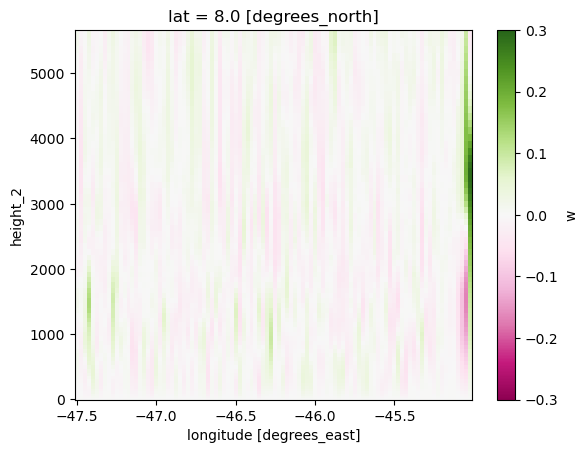

In [64]:
file_list = [os.path.join(tempdir, f) for f in os.listdir(tempdir) if f.startswith('moist_adiabatic_05_DOM01_3D_2020')]

data = xr.open_mfdataset(file_list)
data = reduce_nondimensional(data)
data = replace_height_indices_with_values(data)
kwargs = dict(vmin=-0.3, vmax=0.3, cmap='PiYG')
data[var].mean(dim='time').plot(**kwargs)

In [73]:
# save to disk
data = xr.open_mfdataset(file_list)
data = pp.replace_icon2datetime(data)
data, reference = pp.time_overlap([fh.eureca_data_from_keywords('3D_DOM01'), data])
data = data.mean(dim='time', keep_attrs=True)

infile   = os.path.join(tempdir, "control_nativegrid.nc")
outfile  = os.path.join(tempdir, "control_regridded.nc")

try:    os.remove(infile)
except: pass
data.to_netcdf(infile)

In [74]:
# remap using cdo
infile   = os.path.join(tempdir, "control_nativegrid.nc")
outfile  = os.path.join(tempdir, "control_regridded.nc")
rect = pp.rectangle(lat_lon_iterable)
griddes  = grid_description(rect, (100,100))
griddes_file = save_griddescription(griddes, tempdir)
weight_file = f'{tempdir}weights.nc'
source_grid = '/work/mh1126/m300872/unchanged/grids/EUREC4A_PR1250m_DOM01.nc'

path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_06_pfix'
infiles = fh.list_files(path, ['DOM01_3D'], full_path=True)
dummy_infile = infiles[0]
command = ['cdo', '-O', f'-gendis,{griddes_file}', f'-setgrid,{source_grid}:2', dummy_infile, weight_file] # -O : overwrite
print(' '.join(command), '\n')
subprocess.run(command, stdout=open(os.devnull, 'wb'))

cdo -O -gendis,/scratch/m/m300872/temp_20230220/grid_lonlat_100x100_8.0to16.5N_-47.5to-45.0E.txt -setgrid,/work/mh1126/m300872/unchanged/grids/EUREC4A_PR1250m_DOM01.nc:2 /work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_06_pfix/./moist_adiabatic_06_pfix_DOM01_3D_20200109T100000Z.nc /scratch/m/m300872/temp_20230220/weights.nc 



CompletedProcess(args=['cdo', '-O', '-gendis,/scratch/m/m300872/temp_20230220/grid_lonlat_100x100_8.0to16.5N_-47.5to-45.0E.txt', '-setgrid,/work/mh1126/m300872/unchanged/grids/EUREC4A_PR1250m_DOM01.nc:2', '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_06_pfix/./moist_adiabatic_06_pfix_DOM01_3D_20200109T100000Z.nc', '/scratch/m/m300872/temp_20230220/weights.nc'], returncode=0)

In [75]:
try:    os.remove(outfile)
except: pass
command  = ['cdo', '-O', f'remap,{griddes_file},{weight_file}', f'-setgrid,{source_grid}:2', infile, outfile]
subprocess.run(command)

cdo(1) setgrid: Process started
cdo    remap: Distance-weighted average weights from unstructured (4528560) to lonlat (100x100) grid
cdo(1) setgrid: Processed 3083949360 values from 11 variables over 1 timestep.
cdo    remap: Processed 3083949360 values from 11 variables over 1 timestep [19.02s 9GB].


cdo    remap (Warning): Remap weights from /scratch/m/m300872/temp_20230220/weights.nc not used, unstructured (4528560) grid with mask (4478504) not found!


CompletedProcess(args=['cdo', '-O', 'remap,/scratch/m/m300872/temp_20230220/grid_lonlat_100x100_8.0to16.5N_-47.5to-45.0E.txt,/scratch/m/m300872/temp_20230220/weights.nc', '-setgrid,/work/mh1126/m300872/unchanged/grids/EUREC4A_PR1250m_DOM01.nc:2', '/scratch/m/m300872/temp_20230220/control_nativegrid.nc', '/scratch/m/m300872/temp_20230220/control_regridded.nc'], returncode=0)

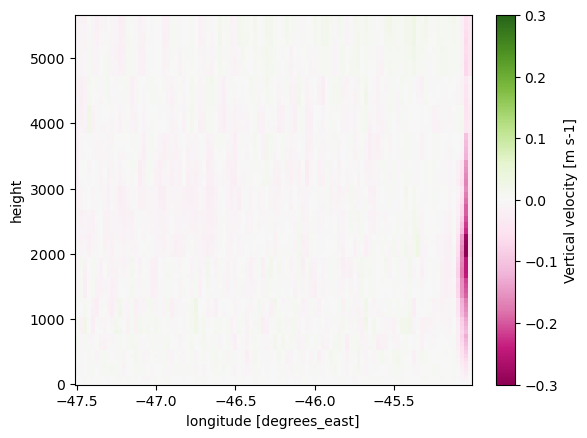

In [76]:
# plot
data = xr.open_dataset(outfile).mean(dim='lat', keep_attrs=True)
data = pp.reduce_nondimensional(data)
data = pp.replace_height_indices_with_values(data, height_names=['height'])
data[var].plot(**kwargs)

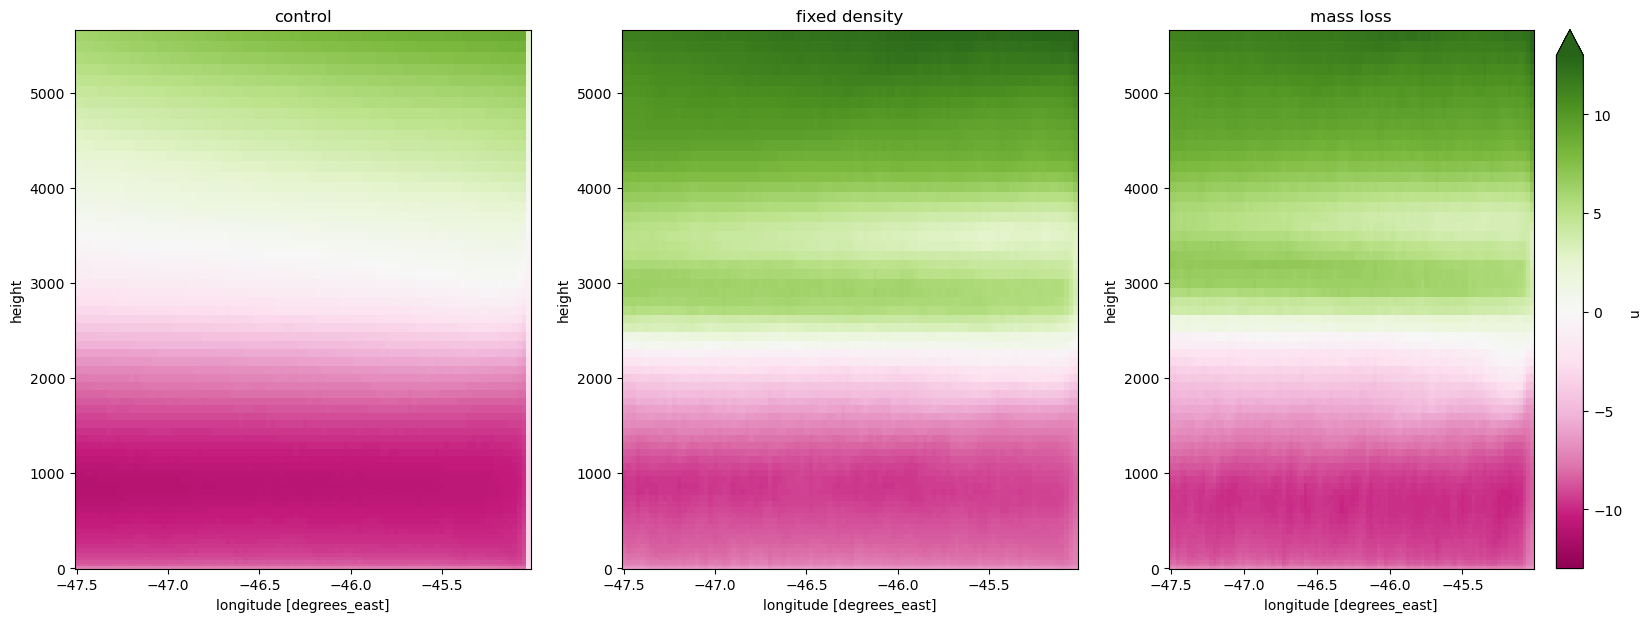

In [105]:
fig, axs = plt.subplots(1,3, figsize=(20,7))

var = 'u'; kwargs['vmax'] = 13; kwargs['vmin'] = -kwargs['vmax']
data = xr.open_dataset(outfile).mean(dim='lat', keep_attrs=True)
data = pp.reduce_nondimensional(data)
data = pp.replace_height_indices_with_values(data, height_names=['height'])
data[var].plot(**kwargs, ax=axs[0], add_colorbar=False)

file_list = [os.path.join(tempdir, f) for f in os.listdir(tempdir) if f.startswith('moist_adiabatic_05_DOM01_3D_2020')]
data = xr.open_mfdataset(file_list)
data = reduce_nondimensional(data)
data = replace_height_indices_with_values(data)
data = data[var].mean(dim='time')
data.plot(**kwargs, ax=axs[1], add_colorbar=False)

file_list = [os.path.join(tempdir, f) for f in os.listdir(tempdir) if f.startswith('moist_adiabatic_06_pfix_DOM01_3D_2020')]
data = xr.open_mfdataset(file_list)
data = reduce_nondimensional(data)
data = replace_height_indices_with_values(data)
data = data[var].mean(dim='time')
data.plot(**kwargs, ax=axs[2], add_colorbar=True)

for ax, title in zip(axs, ['control', 'fixed density', 'mass loss']): ax.set_title(title)

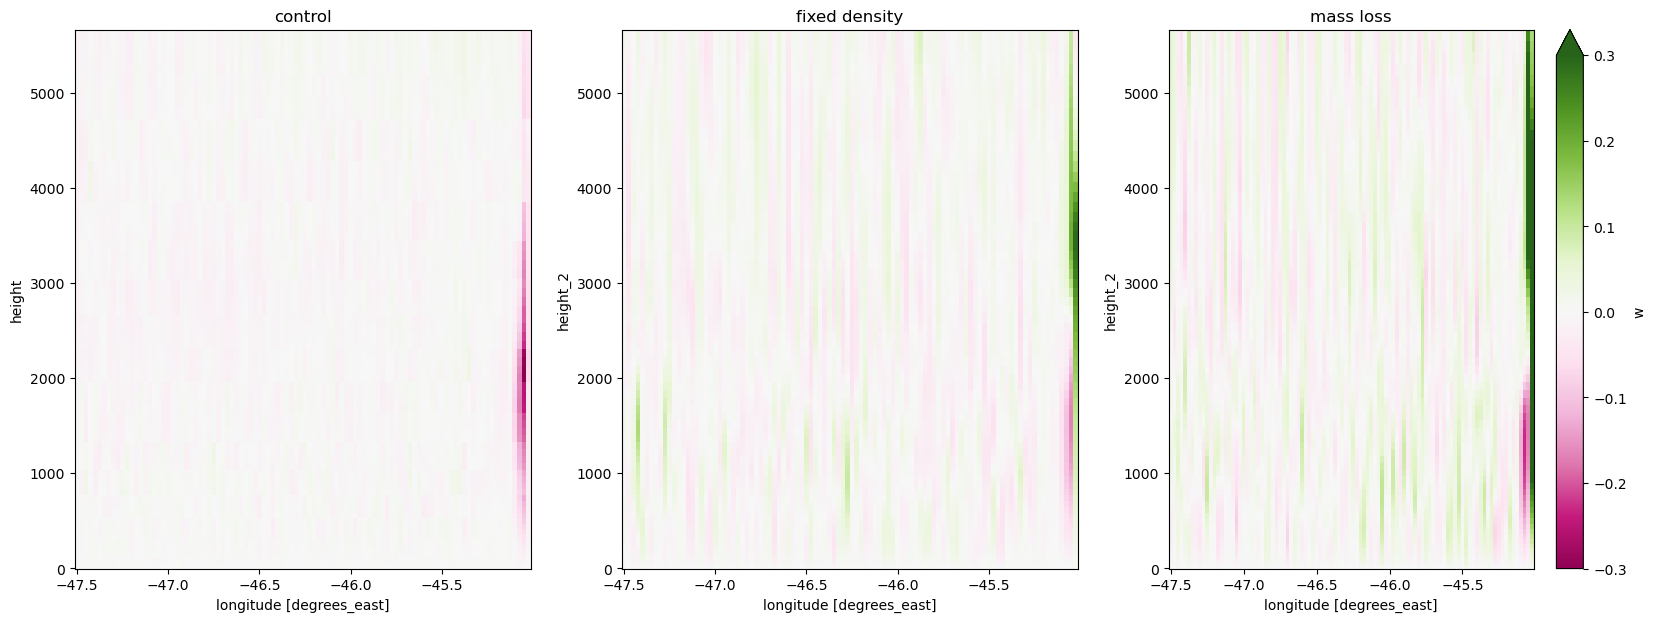

In [104]:
fig, axs = plt.subplots(1,3, figsize=(20,7))

var = 'w'; kwargs['vmax'] = 0.3; kwargs['vmin'] = -kwargs['vmax']
data = xr.open_dataset(outfile).mean(dim='lat', keep_attrs=True)
data = pp.reduce_nondimensional(data)
data = pp.replace_height_indices_with_values(data, height_names=['height'])
data[var].plot(**kwargs, ax=axs[0], add_colorbar=False)

file_list = [os.path.join(tempdir, f) for f in os.listdir(tempdir) if f.startswith('moist_adiabatic_05_DOM01_3D_2020')]
data = xr.open_mfdataset(file_list)
data = reduce_nondimensional(data)
data = replace_height_indices_with_values(data)
data = data[var].mean(dim='time')
data.plot(**kwargs, ax=axs[1], add_colorbar=False)

file_list = [os.path.join(tempdir, f) for f in os.listdir(tempdir) if f.startswith('moist_adiabatic_06_pfix_DOM01_3D_2020')]
data = xr.open_mfdataset(file_list)
data = reduce_nondimensional(data)
data = replace_height_indices_with_values(data)
data = data[var].mean(dim='time')
data.plot(**kwargs, ax=axs[2], add_colorbar=True)

for ax, title in zip(axs, ['control', 'fixed density', 'mass loss']): ax.set_title(title)